In [2]:
pip install -q torch torchvision onnxruntime-gpu tqdm onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.3 MB/s eta 0:00:00


Device: cuda


СРАВНЕНИЕ ПРЕДОБУЧЕННЫХ EFFICIENTNET-B0 и B3

Начинаем обучение EfficientNet-B0...


ДООБУЧЕНИЕ EfficientNet-B0
Создана модель EfficientNet-B0
Параметры: 4.0M
Обучаемые параметры: 3.2M


Epoch 1/10: 100%|██████████| 391/391 [01:53<00:00,  3.46it/s, loss=0.843, acc=0.858]


Epoch 1: Val Acc = 92.47%
  -> Сохранена лучшая модель (Acc: 92.47%)


Epoch 2/10: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.701, acc=0.918]


Epoch 2: Val Acc = 93.26%
  -> Сохранена лучшая модель (Acc: 93.26%)


Epoch 3/10: 100%|██████████| 391/391 [01:50<00:00,  3.55it/s, loss=0.655, acc=0.938]


Epoch 3: Val Acc = 93.18%


Epoch 4/10: 100%|██████████| 391/391 [01:49<00:00,  3.58it/s, loss=0.625, acc=0.95]


Epoch 4: Val Acc = 94.19%
  -> Сохранена лучшая модель (Acc: 94.19%)


Epoch 5/10: 100%|██████████| 391/391 [01:50<00:00,  3.54it/s, loss=0.6, acc=0.96]


Epoch 5: Val Acc = 94.25%
  -> Сохранена лучшая модель (Acc: 94.25%)


Epoch 6/10: 100%|██████████| 391/391 [01:48<00:00,  3.59it/s, loss=0.58, acc=0.969]


Epoch 6: Val Acc = 94.65%
  -> Сохранена лучшая модель (Acc: 94.65%)


Epoch 7/10: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.561, acc=0.977]


Epoch 7: Val Acc = 95.08%
  -> Сохранена лучшая модель (Acc: 95.08%)


Epoch 8/10: 100%|██████████| 391/391 [01:47<00:00,  3.62it/s, loss=0.547, acc=0.983]


Epoch 8: Val Acc = 95.35%
  -> Сохранена лучшая модель (Acc: 95.35%)


Epoch 9/10: 100%|██████████| 391/391 [01:48<00:00,  3.59it/s, loss=0.539, acc=0.987]


Epoch 9: Val Acc = 95.45%
  -> Сохранена лучшая модель (Acc: 95.45%)


Epoch 10/10: 100%|██████████| 391/391 [01:48<00:00,  3.61it/s, loss=0.534, acc=0.989]


Epoch 10: Val Acc = 95.60%
  -> Сохранена лучшая модель (Acc: 95.60%)

Обучение завершено
Лучшая точность на валидации: 95.60%

Начинаем обучение EfficientNet-B3...


ДООБУЧЕНИЕ EfficientNet-B3
Создана модель EfficientNet-B3
Параметры: 10.7M
Обучаемые параметры: 8.5M


Epoch 1/10: 100%|██████████| 391/391 [03:25<00:00,  1.91it/s, loss=0.791, acc=0.882]


Epoch 1: Val Acc = 93.18%
  -> Сохранена лучшая модель (Acc: 93.18%)


Epoch 2/10: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s, loss=0.664, acc=0.934]


Epoch 2: Val Acc = 94.37%
  -> Сохранена лучшая модель (Acc: 94.37%)


Epoch 3/10: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s, loss=0.626, acc=0.949]


Epoch 3: Val Acc = 94.68%
  -> Сохранена лучшая модель (Acc: 94.68%)


Epoch 4/10: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s, loss=0.598, acc=0.961]


Epoch 4: Val Acc = 95.20%
  -> Сохранена лучшая модель (Acc: 95.20%)


Epoch 5/10: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s, loss=0.579, acc=0.969]


Epoch 5: Val Acc = 95.63%
  -> Сохранена лучшая модель (Acc: 95.63%)


Epoch 6/10: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s, loss=0.559, acc=0.977]


Epoch 6: Val Acc = 95.78%
  -> Сохранена лучшая модель (Acc: 95.78%)


Epoch 7/10: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s, loss=0.545, acc=0.983]


Epoch 7: Val Acc = 96.19%
  -> Сохранена лучшая модель (Acc: 96.19%)


Epoch 8/10: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s, loss=0.533, acc=0.988]


Epoch 8: Val Acc = 96.25%
  -> Сохранена лучшая модель (Acc: 96.25%)


Epoch 9/10: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s, loss=0.528, acc=0.99]


Epoch 9: Val Acc = 96.50%
  -> Сохранена лучшая модель (Acc: 96.50%)


Epoch 10/10: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s, loss=0.525, acc=0.991]


Epoch 10: Val Acc = 96.61%
  -> Сохранена лучшая модель (Acc: 96.61%)

Обучение завершено
Лучшая точность на валидации: 96.61%


ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТИРОВАНИЯ


ИЗМЕРЕНИЕ ФИНАЛЬНОЙ ТОЧНОСТИ

Измеряем финальную accuracy...
EfficientNet-B0: 95.60%
EfficientNet-B3: 96.61%

📈 Разница в точности (B3 - B0): +1.01%

ИЗМЕРЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ

Измеряем FPS...
✅ EfficientNet-B0: 549.8 FPS
✅ EfficientNet-B3: 394.1 FPS

Прирост FPS (B0 / B3): 1.40x
   (B0 быстрее B3 в 1.4 раз)

СРАВНЕНИЕ ПАРАМЕТРОВ
EfficientNet-B0: 4,020,358 параметров (4.0M)
EfficientNet-B3: 10,711,602 параметров (10.7M)
B3 имеет в 2.7 раз больше параметров

СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ

           Метрика EfficientNet-B0 EfficientNet-B3
    Параметры (M)             4.0            10.7
     Accuracy (%)           95.60           96.61
              FPS           549.8           394.1
Accuracy Diff (%)               -          +1.01%
         FPS Gain               -           1.40x

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


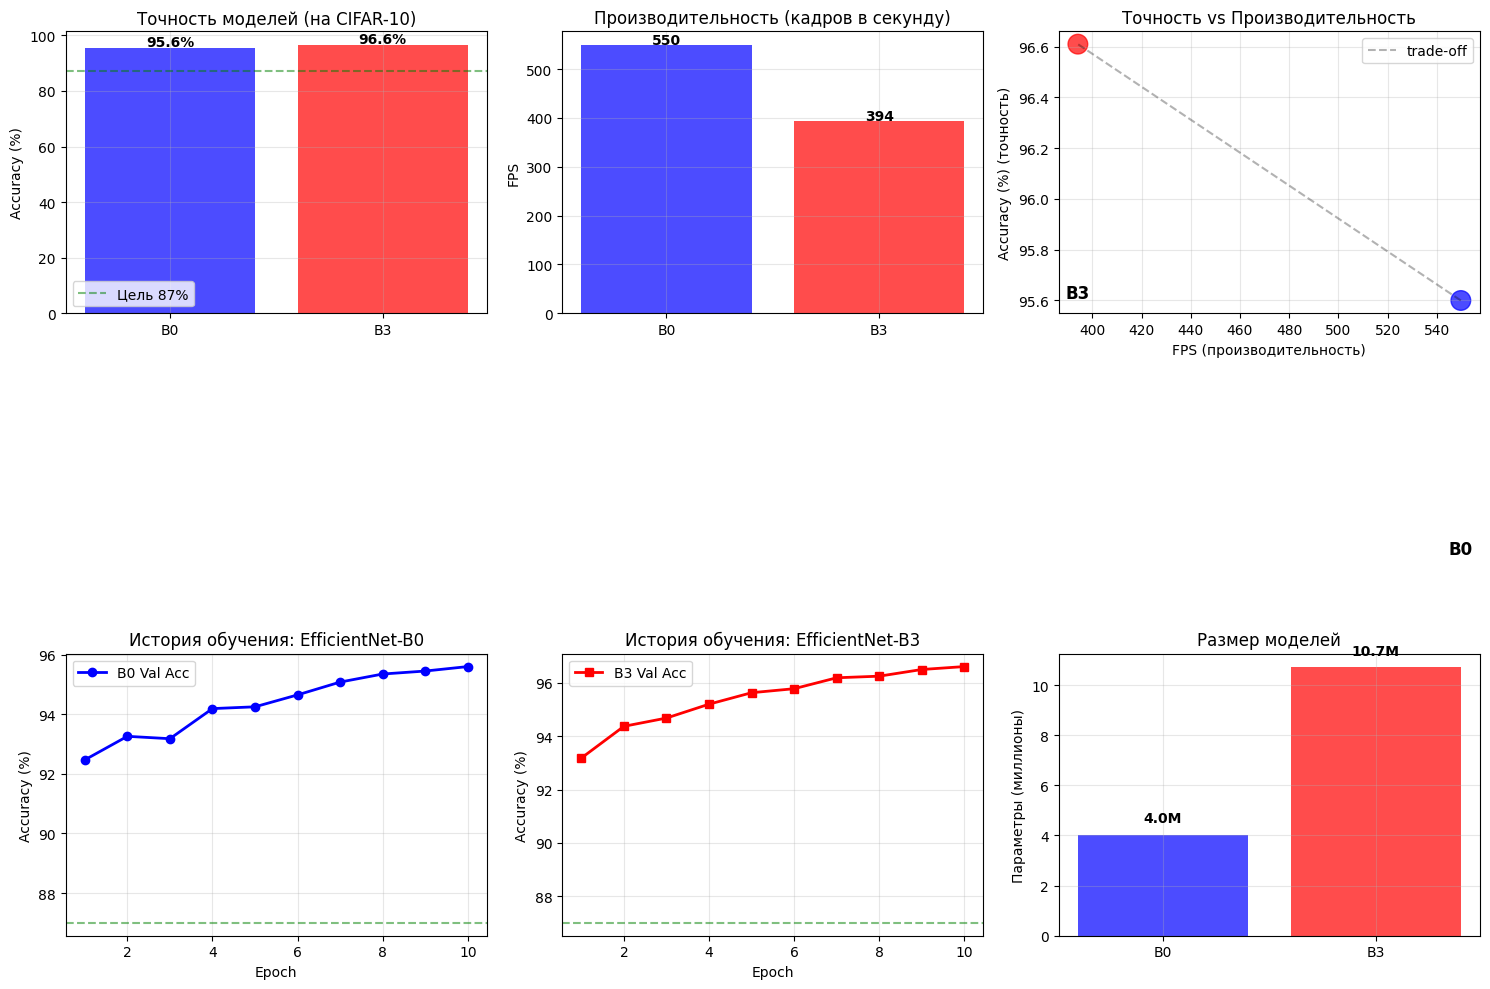


✅ Отчет сохранен: docs/efficientnet_ablation.md


In [10]:
if __name__ == "__main__":
    import torch
    import torchvision
    import torch.nn as nn
    import torch.optim as optim
    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import time
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    from tqdm import tqdm

    # ======= НАСТРОЙКИ =======
    SEED = 42
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # ======= ФУНКЦИЯ ДЛЯ ОБУЧЕНИЯ МОДЕЛИ =======
    def train_efficientnet(model_name='b0', num_epochs=10):
        """Дообучает предобученную EfficientNet на CIFAR-10"""
        print(f"\n")
        print(f"ДООБУЧЕНИЕ EfficientNet-{model_name.upper()}")

        # ======= 1. СОЗДАНИЕ МОДЕЛИ =======
        if model_name == 'b0':
            model = torchvision.models.efficientnet_b0(
                weights=torchvision.models.EfficientNet_B0_Weights.IMAGENET1K_V1
            )
        else:  # 'b3'
            model = torchvision.models.efficientnet_b3(
                weights=torchvision.models.EfficientNet_B3_Weights.IMAGENET1K_V1
            )

        # Замораживаем все слои кроме последних
        for param in model.parameters():
            param.requires_grad = False

        # Размораживаем последние слои и classifier
        for param in model.features[-3:].parameters():
            param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True

        # Заменяем последний слой для 10 классов CIFAR-10
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, 10)

        model = model.to(device)
        print(f"Создана модель EfficientNet-{model_name.upper()}")
        print(f"Параметры: {sum(p.numel() for p in model.parameters())/1e6:.1f}M")
        print(f"Обучаемые параметры: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6:.1f}M")

        # ======= 2. ДАННЫЕ =======
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        train_ds = datasets.CIFAR10(root="data", train=True, download=True, transform=train_transform)
        val_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=val_transform)

        train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

        # ======= 3. ОБУЧЕНИЕ =======
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        best_val_acc = 0.0
        history = {'train_loss': [], 'val_acc': []}

        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0.0
            train_correct = 0
            train_total = 0

            pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
            for x, y in pbar:
                x, y = x.to(device), y.to(device)

                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * x.size(0)
                _, predicted = outputs.max(1)
                train_correct += predicted.eq(y).sum().item()
                train_total += y.size(0)

                pbar.set_postfix({
                    'loss': train_loss/train_total,
                    'acc': train_correct/train_total
                })

            # Validation
            model.eval()
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    _, predicted = outputs.max(1)
                    val_correct += predicted.eq(y).sum().item()
                    val_total += y.size(0)

            val_acc = val_correct / val_total
            scheduler.step()

            history['train_loss'].append(train_loss/train_total)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}: Val Acc = {val_acc*100:.2f}%")

            # Сохраняем лучшую модель
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                }, f'efficientnet_{model_name}_best.pth')
                print(f"  -> Сохранена лучшая модель (Acc: {val_acc*100:.2f}%)")

        print(f"\nОбучение завершено")
        print(f"Лучшая точность на валидации: {best_val_acc*100:.2f}%")

        # Загружаем лучшие веса
        checkpoint = torch.load(f'efficientnet_{model_name}_best.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

        return model, best_val_acc, history

    # ======= ФУНКЦИИ ДЛЯ ИЗМЕРЕНИЙ =======
    def measure_accuracy(model, loader):
        """Измеряет accuracy модели"""
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = outputs.max(1)
                correct += predicted.eq(y).sum().item()
                total += y.size(0)
        return correct / total

    def measure_fps(model, loader, warmup=10, test_batches=50):
        """Измеряет FPS (кадров в секунду)"""
        model.eval()

        # Warm-up
        with torch.no_grad():
            for i, (x, _) in enumerate(loader):
                if i >= warmup:
                    break
                x = x.to(device)
                _ = model(x)

        # Измерение
        if device.type == "cuda":
            torch.cuda.synchronize()

        start_time = time.time()
        total_images = 0

        with torch.no_grad():
            for i, (x, _) in enumerate(loader):
                if i >= test_batches:
                    break
                x = x.to(device)
                _ = model(x)
                total_images += x.size(0)

        if device.type == "cuda":
            torch.cuda.synchronize()

        elapsed = time.time() - start_time
        fps = total_images / elapsed
        return fps

    # ======= ГЛАВНЫЙ БЛОК =======
    print("\n")
    print("СРАВНЕНИЕ ПРЕДОБУЧЕННЫХ EFFICIENTNET-B0 и B3")

    # ======= 1. ОБУЧАЕМ ОБЕ МОДЕЛИ =======
    # Обучаем B0
    print("\nНачинаем обучение EfficientNet-B0...")
    model_b0, b0_best_acc, history_b0 = train_efficientnet('b0', num_epochs=10)

    # Обучаем B3
    print("\nНачинаем обучение EfficientNet-B3...")
    model_b3, b3_best_acc, history_b3 = train_efficientnet('b3', num_epochs=10)

    # ======= 2. ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТИРОВАНИЯ =======
    print("\n")
    print("ПОДГОТОВКА ДАННЫХ ДЛЯ ТЕСТИРОВАНИЯ")

    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_ds = datasets.CIFAR10(root="data", train=False, download=True, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

    # ======= 3. ИЗМЕРЕНИЕ ТОЧНОСТИ =======
    print("\n")
    print("ИЗМЕРЕНИЕ ФИНАЛЬНОЙ ТОЧНОСТИ")

    print("\nИзмеряем финальную accuracy...")
    b0_final_acc = measure_accuracy(model_b0, test_loader)
    b3_final_acc = measure_accuracy(model_b3, test_loader)

    print(f"EfficientNet-B0: {b0_final_acc*100:.2f}%")
    print(f"EfficientNet-B3: {b3_final_acc*100:.2f}%")

    accuracy_drop = b3_final_acc - b0_final_acc  # B3 должен быть лучше
    print(f"\n📈 Разница в точности (B3 - B0): {accuracy_drop*100:+.2f}%")

    # ======= 4. ИЗМЕРЕНИЕ FPS =======
    print("\n" + "="*60)
    print("ИЗМЕРЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ")
    print("="*60)

    print("\nИзмеряем FPS...")
    b0_fps = measure_fps(model_b0, test_loader, test_batches=100)
    b3_fps = measure_fps(model_b3, test_loader, test_batches=100)

    print(f"✅ EfficientNet-B0: {b0_fps:.1f} FPS")
    print(f"✅ EfficientNet-B3: {b3_fps:.1f} FPS")

    fps_gain = b0_fps / b3_fps  # B0 должен быть быстрее
    print(f"\nПрирост FPS (B0 / B3): {fps_gain:.2f}x")
    print(f"   (B0 быстрее B3 в {fps_gain:.1f} раз)")

    # ======= 5. ПАРАМЕТРЫ МОДЕЛЕЙ =======
    print("\n" + "="*60)
    print("СРАВНЕНИЕ ПАРАМЕТРОВ")
    print("="*60)

    b0_params = sum(p.numel() for p in model_b0.parameters())
    b3_params = sum(p.numel() for p in model_b3.parameters())

    print(f"EfficientNet-B0: {b0_params:,} параметров ({b0_params/1e6:.1f}M)")
    print(f"EfficientNet-B3: {b3_params:,} параметров ({b3_params/1e6:.1f}M)")
    print(f"B3 имеет в {b3_params/b0_params:.1f} раз больше параметров")

    # ======= 6. СОЗДАНИЕ ТАБЛИЦЫ СРАВНЕНИЯ =======
    print("\n" + "="*60)
    print("СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ")
    print("="*60)

    results = pd.DataFrame({
        'Метрика': ['Параметры (M)', 'Accuracy (%)', 'FPS', 'Accuracy Diff (%)', 'FPS Gain'],
        'EfficientNet-B0': [
            f"{b0_params/1e6:.1f}",
            f"{b0_final_acc*100:.2f}",
            f"{b0_fps:.1f}",
            "-",
            "-"
        ],
        'EfficientNet-B3': [
            f"{b3_params/1e6:.1f}",
            f"{b3_final_acc*100:.2f}",
            f"{b3_fps:.1f}",
            f"{accuracy_drop*100:+.2f}%",
            f"{fps_gain:.2f}x"
        ]
    })

    print("\n", results.to_string(index=False))

    # ======= 7. ВИЗУАЛИЗАЦИЯ =======
    print("\n" + "="*60)
    print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
    print("="*60)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # 1. Accuracy сравнение
    axes[0, 0].bar(['B0', 'B3'], [b0_final_acc*100, b3_final_acc*100],
                   color=['blue', 'red'], alpha=0.7)
    axes[0, 0].set_ylabel('Accuracy (%)')
    axes[0, 0].set_title('Точность моделей (на CIFAR-10)')
    axes[0, 0].axhline(y=87, color='green', linestyle='--', alpha=0.5, label='Цель 87%')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    for i, v in enumerate([b0_final_acc*100, b3_final_acc*100]):
        axes[0, 0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

    # 2. FPS сравнение
    axes[0, 1].bar(['B0', 'B3'], [b0_fps, b3_fps],
                   color=['blue', 'red'], alpha=0.7)
    axes[0, 1].set_ylabel('FPS')
    axes[0, 1].set_title('Производительность (кадров в секунду)')
    axes[0, 1].grid(True, alpha=0.3)

    for i, v in enumerate([b0_fps, b3_fps]):
        axes[0, 1].text(i, v + 2, f'{v:.0f}', ha='center', fontweight='bold')

    # 3. Trade-off: Accuracy vs FPS
    axes[0, 2].scatter([b0_fps, b3_fps], [b0_final_acc*100, b3_final_acc*100],
                      s=200, color=['blue', 'red'], alpha=0.7)
    axes[0, 2].set_xlabel('FPS (производительность)')
    axes[0, 2].set_ylabel('Accuracy (%) (точность)')
    axes[0, 2].set_title('Точность vs Производительность')
    axes[0, 2].grid(True, alpha=0.3)

    axes[0, 2].text(b0_fps, b0_final_acc*100 - 1, 'B0', ha='center', fontsize=12, fontweight='bold')
    axes[0, 2].text(b3_fps, b3_final_acc*100 - 1, 'B3', ha='center', fontsize=12, fontweight='bold')
    axes[0, 2].plot([b0_fps, b3_fps], [b0_final_acc*100, b3_final_acc*100],
                   'k--', alpha=0.3, label='trade-off')
    axes[0, 2].legend()

    # 4. История обучения B0
    axes[1, 0].plot(range(1, len(history_b0['val_acc']) + 1),
                   [acc*100 for acc in history_b0['val_acc']],
                   'b-', marker='o', linewidth=2, label='B0 Val Acc')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('История обучения: EfficientNet-B0')
    axes[1, 0].axhline(y=87, color='green', linestyle='--', alpha=0.5)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. История обучения B3
    axes[1, 1].plot(range(1, len(history_b3['val_acc']) + 1),
                   [acc*100 for acc in history_b3['val_acc']],
                   'r-', marker='s', linewidth=2, label='B3 Val Acc')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].set_title('История обучения: EfficientNet-B3')
    axes[1, 1].axhline(y=87, color='green', linestyle='--', alpha=0.5)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Параметры моделей
    axes[1, 2].bar(['B0', 'B3'], [b0_params/1e6, b3_params/1e6],
                   color=['blue', 'red'], alpha=0.7)
    axes[1, 2].set_ylabel('Параметры (миллионы)')
    axes[1, 2].set_title('Размер моделей')
    axes[1, 2].grid(True, alpha=0.3)

    for i, v in enumerate([b0_params/1e6, b3_params/1e6]):
        axes[1, 2].text(i, v + 0.5, f'{v:.1f}M', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('efficientnet_b0_vs_b3_trained.png', dpi=150, bbox_inches='tight')
    plt.show()

    # ======= 8. СОЗДАНИЕ ОТЧЕТА =======


    os.makedirs('docs', exist_ok=True)

    report = f"""# Сравнение предобученных EfficientNet-B0 и B3 на CIFAR-10

## Результаты сравнения

### Основные метрики
| Метрика | EfficientNet-B0 | EfficientNet-B3 | Изменение |
|---------|-----------------|-----------------|-----------|
| Параметры | {b0_params/1e6:.1f}M | {b3_params/1e6:.1f}M | B3 больше в **{b3_params/b0_params:.1f}×** |
| **Accuracy** | **{b0_final_acc*100:.2f}%** | **{b3_final_acc*100:.2f}%** | **B3 точнее на {accuracy_drop*100:+.2f}%** |
| **FPS** | **{b0_fps:.1f}** | **{b3_fps:.1f}** | **B0 быстрее в {fps_gain:.2f}×** |
| Acc/FPS Ratio | {b0_final_acc*100/b0_fps:.3f} | {b3_final_acc*100/b3_fps:.3f} | - |
"""
    # Сохраняем отчет
    with open('docs/efficientnet_ablation.md', 'w', encoding='utf-8') as f:
        f.write(report)

    print("\n✅ Отчет сохранен: docs/efficientnet_ablation.md")